# **LAB 01:** Thu nhập dữ liệu và trực quan hóa dữ liệu

### **Thông tin thành viên**

|   MMSV   |  Họ và tên  |
|:--------:|:-----------:|
| 22127117 | Lý Liên Hoa |
| 22127352 | Võ Anh Quân |

## **Tóm tắt đồ án**

Hiện nay, các nền tảng nghe nhạc trực tuyến như Spotify, Zing MP3, Nhaccuatui, SoundCloud, ... là một trong
những kênh để nghe nhạc và khám phá các xu hướng âm nhạc mới. Trên các nền tảng này chứa dữ liệu khổng
lồ về các thông tin bài hát, nghệ sĩ, thể loại.  

Ở đò án này, nhóm chúng em chọn thu thập dữ liệu và thực hiện việc phân tích dữ liệu về thống kê, xu hướng âm nhạc của người dùng hiện này trên một trong những trang web âm nhạc trực tuyến lớn nhất Việt Nam - **Zing MP3**.    

Với trong [QUYỀN HẠN](https://zingmp3.vn/robots.txt) cho phép, việc thu thập dữ liệu sẽ được thực hiện trên trang Zing MP3 có chứa các album top 100 bài hát hay ở mỗi thể loại hiện nay bằng cách sử dụng **Selenium**. Sau khi hoàn thành, có tổng cộng **3506 records** và **8 thuộc tính** (bao gồm "Album".	"Tên bài hát", "Lượt yêu thích", "Lượt nghe", "Nghệ sĩ", "Sáng tác", "Thể loại", "Nhà cung cấp")

Dữ liệu được cập nhật lần cuối vào 19/02/2025

## **Phần 1: Thu thập dữ liệu**

### **Thư viện**

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

### **1. Hàm lấy thông tin các bài hát có trong một album**

In [ ]:
def init_driver():
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--start-maximized")  # Bật full màn hình
    driver = webdriver.Chrome(options=chrome_options)
    return driver
    

def close_popup(driver):
    try:
        close_button = WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.CLASS_NAME, "close-btn")))
        close_button.click()
        print("--> Popup đã đóng!")
        time.sleep(1)
    except:
        print("--> Không có popup!")

In [ ]:
def get_song_info_from_portal(portal_element):
    # Tên bài hát
    try:
        song_title = portal_element.find_element(By.CLASS_NAME, "item-title").text
    except:
        song_title = None
    # Lượt thích
    try:
        likes = portal_element.find_element(By.XPATH, "//div[@class='stat-item']/i[contains(@class, 'ic-like')]/following-sibling::span").text
    except:
        likes = None
    # Lượt nghe
    try:
        views = portal_element.find_element(By.XPATH, "//div[@class='stat-item']/i[contains(@class, 'ic-view')]/following-sibling::span").text
    except:
        views = None
        
    return song_title, likes, views

In [ ]:
def extract_info_from_submenu(submenu, label):
    try:
        return submenu.find_element(By.XPATH, f".//h3[contains(text(), '{label}')]/following-sibling::div").text
    except:
        return None
    
def get_submenu_info(driver, portal_element):
    actions = ActionChains(driver)
    try:
        song_image = portal_element.find_element(By.TAG_NAME, "img")  # Tìm hình ảnh xuất hiện trên portal
        actions.move_to_element(song_image).perform()  # Di chuyển chuột tới hình ảnh đó
        time.sleep(2)  

        submenu = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.CLASS_NAME, "submenu-content"))
        )

        artist = extract_info_from_submenu(submenu, "Nghệ sĩ")
        album = extract_info_from_submenu(submenu, "Album")
        composer = extract_info_from_submenu(submenu, "Sáng tác")
        genre = extract_info_from_submenu(submenu, "Thể loại")
        provided_by = extract_info_from_submenu(submenu, "Cung cấp bởi")

    except:
        print(f"Không thể hover vào hình ảnh bài hát.")
        artist, album, composer, genre, provided_by = None, None, None, None, None

    return artist, album, composer, genre, provided_by

##### Hàm chính lấy thông tin các bài hát trong album

In [ ]:
def get_info_songs_album(driver, url, album_title):
    print(f"\n => Đang thu thập dữ liệu từ album: {album_title} | URL: {url}")

    # TRUY CẬP TRANG WEB CỦA ALBUM
    driver.get(url)
    time.sleep(5)
    
    # ĐÓNG POPUP (NẾU CÓ)
    close_popup(driver)
    
    # TÌM DANH SÁCH CÁC BÀI HÁT
    songs = driver.find_elements(By.CLASS_NAME, "media-left")[2:]
    song_data = []

    # LẤY THÔNG TIN CỦA TỪNG BÀI HÁT
    for index, song in enumerate(songs):  
        try:
            # 1. Click chuột phải vào tên Album của bài hát để mở menu ngữ cảnh (có chứa các thông tin về bài hát)
            actions = ActionChains(driver)
            actions.context_click(song).perform()
            time.sleep(2)

            # 2. Sau khi click chuột phải, tìm portal xuất hiện trên web
            portal_element = WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.CLASS_NAME, "zm-portal"))
            )

            # 3. Lấy thông tin bài hát từ portal đó
            song_title, likes, views = get_song_info_from_portal(portal_element)

            # 4. Hover chuột vào hình ảnh để hiển thị submenu-content trên web
            artist, album, composer, genre, provided_by = get_submenu_info(driver, portal_element)

            # 5. Lưu vào danh sách
            song_data.append({
                "Tên bài hát": song_title,
                "Album": album,
                "Lượt yêu thích": likes,
                "Lượt nghe": views,
                "Nghệ sĩ": artist,
                "Sáng tác": composer,
                "Thể loại": genre,
                "Nhà cung cấp": provided_by
            })

            print(f"{index+1}. {song_title} | {artist} | {album} | {composer} | {genre} | {provided_by} | {likes} | {views}")

            # Đóng portal hiện tại để tránh lỗi khi click bài tiếp theo
            driver.execute_script("document.querySelector('.zm-portal').remove();")

        except Exception as e:
            print(f"Lỗi khi lấy bài hát {index}: {e}")

    return song_data

### **2. Hàm lấy tất cả bài hát có trong tất cả album**

In [ ]:
def wait_album_list(driver):
    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//h4[@class='title is-6']/a"))
        )
        print("Danh sách album đã xuất hiện!")
    except:
        print("Không tìm thấy danh sách album. Kiểm tra lại XPath hoặc chờ tải trang lâu hơn.")
        driver.quit()
        return False
    
    return True

In [ ]:
def get_albums_at_present(driver, album_links, seen_albums):
    albums = driver.find_elements(By.XPATH, "//h4[@class='title is-6']/a")
    new_count = 0

    for album in albums:
        try:
            album_title = album.get_attribute("title").strip()
            album_url = album.get_attribute("href").strip()

            if album_url not in seen_albums:
                album_links.append((album_title, album_url))
                seen_albums.add(album_url)
                new_count += 1
        except:
            continue

    return new_count

def collect_albums(driver):
    album_links = []  # Dùng list để lưu theo thứ tự
    seen_albums = set()  # Dùng set để tránh trùng lặp

    while True:
        new_albums = get_albums_at_present(driver, album_links, seen_albums)
        if new_albums == 0:  # Nếu không có album mới, dừng lại
            break
        driver.execute_script("window.scrollBy(0, 600);")  # Cuộn xuống một chút
        time.sleep(1)

    print(f"Tổng số album tìm thấy: {len(album_links)}")
    
    return album_links

In [ ]:
def crawling_songs():
    print("\nBắt đầu thu thập dữ liệu ...")
    driver = init_driver()

    # TRUY CẬP TRANG WEB CHỨA CÁC ALBUM TOP 100
    top100_url = "https://zingmp3.vn/top100"
    driver.get(top100_url)
    time.sleep(5)  # Chờ trang tải

    # ĐÓNG POPUP (NẾU CÓ)
    close_popup(driver)

    # 1. Chờ danh sách các album xuất hiện trên web
    if not wait_album_list(driver):
        return

    # 2. Lấy tất cả album có mặt trên web trước khi cuộn xuống lấy tiếp
    album_links = collect_albums(driver)

    if len(album_links) == 0: # Không có album
        print("Không tìm thấy album nào :(")
        return

    # 3. Lưu dữ liệu bài hát từ tất cả album
    all_song_data = []

    # 4. Duyệt qua từng album để lấy danh sách bài hát theo thứ tự
    for album_title, album_url in album_links:
        song_data = get_info_songs_album(driver, album_url, album_title)
        all_song_data.extend(song_data)

    # Đóng trình duyệt
    driver.quit()

    # 5. Lưu tất cả bài hát vào file csv
    df = pd.DataFrame(all_song_data)
    
    csv_filename = "songs_df.csv"
    df.to_csv(csv_filename, index=False, encoding="utf-8-sig")

    print(f"\n Dữ liệu từ tất cả album Top 100 đã được lưu vào tệp: {csv_filename}")

    return df


#### **Bắt đầu thu thập dữ liệu**

In [ ]:
crawling_songs()

## **Phần 2: Khám phá, phân tích và tiền xử lý dữ liệu**

### **1. Khám phá dữ liệu**

#### **Thiết lập tùy chọn hiển thị**

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)

#### **Đọc dữ liệu**

In [3]:
df = pd.read_csv('./Data/songs_df.csv')

df.head(10)

,Tên bài hát,Album,Lượt yêu thích,Lượt nghe,Nghệ sĩ,Sáng tác,Thể loại,Nhà cung cấp
0,Mất Kết Nối,Dữ Liệu Quý (EP),582K,23.6M,Dương Domic,Dương Domic,"Việt Nam, V-Pop",DAO Music Entertainment
1,Tái Sinh,MULTIVERSE,744K,24.1M,Tùng Dương,Tăng Duy Tân,"Việt Nam, V-Pop",+84 Vietnam New Wave
2,Mộng Hoa Sim,Mộng Hoa Sim (Single),NaN,NaN,Thiên Tú,Thiên Tú,"Việt Nam, V-Pop",MIXUS
3,Anh Đau Từ Lúc Em Đi,Anh Đau Từ Lúc Em Đi (Single),501K,18.1M,Trần Mạnh Cường,Trần Mạnh Cường,"Việt Nam, V-Pop",Incom
4,Cảm Ơn Em,Cảm Ơn Em (Single),279K,10M,Đặng Thiên Chí,Đặng Thiên Chí,"Việt Nam, V-Pop",VIEENT Music
5,Ánh Mắt Biết Cười,Ánh Mắt Biết Cười (Single),103K,2.8M,"Quang Hùng MasterD, Tăng Duy Tân","Lê Quang Hùng, Tăng Duy Tân","Việt Nam, V-Pop",Euphoria Media Vietnam
6,E Là Không Thể,E Là Không Thể (Single),398K,16.2M,Anh Quân,Đông Thiên Đức,"Việt Nam, V-Pop",DAO Music Entertainment
7,Thủy Triều,Thủy Triều (Single),NaN,NaN,Quang Hùng MasterD,Quang Hùng MasterD,"Việt Nam, V-Pop",Euphoria Media Vietnam
8,Cô Phòng,Cô Phòng (EP),NaN,NaN,"Hồ Quang Hiếu, Huỳnh Văn",Huỳnh Văn,"Việt Nam, V-Pop",TECHBEAT Music
9,Tự Hào Màu Áo Lính,Tự Hào Màu Áo Lính (Single),NaN,NaN,Thái Học,Long Họ Huỳnh,"Việt Nam, V-Pop",MIXUS


#### **Kích thước dữ liệu**

In [4]:
df.size

28768

#### **Hình dạng dữ liệu**

In [5]:
n_rows, n_cols = df.shape

print(f"Số lượng dòng: {n_rows}")
print(f"Số lượng cột: {n_cols}")

Số lượng dòng: 3596
Số lượng cột: 8


#### **Thông tin cơ bản**

- **Ý nghĩa của mỗi dòng dữ liệu**:  Mỗi dòng trong tập dữ liệu là thông tin cơ bản của một bài hát cụ thể như tên bài hát, nghệ sĩ, sáng tác, ...

- **Ý nghĩa của mỗi cột dữ liệu**: 

| Thuộc tính     | Ý nghĩa                                                                           |
|----------------|----------------------------------------------------------------------------------:|
| Album          | Tên album mà bài hát thuộc về (nếu có). Một số bài hát có thể là Single (Đĩa đơn) |
| Tên bài hát    | Tên của bài hát                                                                   |
| Lượt yêu thích | Tổng số lượng người yêu thích bài hát                                             |
| Lượt nghe      | Tổng số lượt nghe bài hát                                                         |
| Nghệ sĩ        | Tên của (các) ca sĩ hoặc nhóm nhạc trình bày bài hát                              |
| Sáng tác       | Tên của nhạc sĩ hoặc nhóm viết bài hát                                            |
| Thể loại       | Thể loại âm nhạc của bài hát                                                      |
| Nhà cung cấp   | Công ty hoặc đơn vị, cá nhân phát hành và phân phối bài hát trên nền tảng nhạc    |

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3596 entries, 0 to 3595
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Tên bài hát     3596 non-null   object
 1   Album           3340 non-null   object
 2   Lượt yêu thích  1150 non-null   object
 3   Lượt nghe       1150 non-null   object
 4   Nghệ sĩ         3576 non-null   object
 5   Sáng tác        2654 non-null   object
 6   Thể loại        3521 non-null   object
 7   Nhà cung cấp    3581 non-null   object
dtypes: object(8)
memory usage: 224.9+ KB


### **2. Tiền xử lý và phân tích dữ liệu**

#### **Kiểm tra có dòng nào bị lặp lại không?**

In [7]:
duplicated_rows = df.duplicated().sum()

print(f"--> Tổng số dòng bị lặp: {duplicated_rows}")

--> Tổng số dòng bị lặp: 192


- Xóa tất cả dòng bị lặp giữ nguyên dòng đầu tiên

In [8]:
df_cleaned = df.drop_duplicates(keep='first')

print(f"--> Hình dạng tập dữ liệu sau khi loại bỏ trùng lập: {df_cleaned.shape}")

--> Hình dạng tập dữ liệu sau khi loại bỏ trùng lập: (3404, 8)


#### **Kiểm tra kiểu dữ liệu của từng cột có thích hợp không?**

In [9]:
df_cleaned.dtypes

Tên bài hát       object
Album             object
Lượt yêu thích    object
Lượt nghe         object
Nghệ sĩ           object
Sáng tác          object
Thể loại          object
Nhà cung cấp      object
dtype: object

- `Lượt yêu thích` và `Lượt nghe` được lưu dươi dạng đơn vị 'K' (nếu giá trị nằm trong khoảng $1000 - 999,999$), 'M' (nếu giá trị nằm trong khoảng $1$ triệu đổ lên), và không có đơn vị (nếu giá trị nhỏ hơn $1000$).

$\rightarrow$ Chuyển đổi sang dạng numeric bằng cách lấy giá trị trước 'K' và 'M', lần lượt nhân với $1,000$ (đối với 'K') và $1,000,000$ (đối với 'M').

In [10]:
def convert_to_numeric(str_val):
    if str_val is None or str_val == 'NaN':
        return None
    
    if isinstance(str_val, str):
        val = float(str_val.strip('K, M'))
        
        if 'K' in str_val:
            return val * 1000
        elif 'M' in str_val:
            return val * 1e6
    
    return str_val

In [11]:
df_cleaned = df_cleaned.copy()

In [12]:
df_cleaned.loc[:, 'Lượt yêu thích (dễ nhìn)'] = df_cleaned['Lượt yêu thích']
df_cleaned.loc[:, 'Lượt nghe (dễ nhìn)'] = df_cleaned['Lượt nghe']

In [13]:
df_cleaned.loc[:, 'Lượt yêu thích'] = df_cleaned['Lượt yêu thích (dễ nhìn)'].apply(convert_to_numeric)
df_cleaned.loc[:, 'Lượt nghe'] = df_cleaned['Lượt nghe (dễ nhìn)'].apply(convert_to_numeric)

df_cleaned['Lượt yêu thích'] = df_cleaned['Lượt yêu thích'].astype('float64')
df_cleaned['Lượt nghe'] = df_cleaned['Lượt nghe'].astype('float64')

df_cleaned.head(10)

,Tên bài hát,Album,Lượt yêu thích,Lượt nghe,Nghệ sĩ,Sáng tác,Thể loại,Nhà cung cấp,Lượt yêu thích (dễ nhìn),Lượt nghe (dễ nhìn)
0,Mất Kết Nối,Dữ Liệu Quý (EP),582000.0,23600000.0,Dương Domic,Dương Domic,"Việt Nam, V-Pop",DAO Music Entertainment,582K,23.6M
1,Tái Sinh,MULTIVERSE,744000.0,24100000.0,Tùng Dương,Tăng Duy Tân,"Việt Nam, V-Pop",+84 Vietnam New Wave,744K,24.1M
2,Mộng Hoa Sim,Mộng Hoa Sim (Single),NaN,NaN,Thiên Tú,Thiên Tú,"Việt Nam, V-Pop",MIXUS,NaN,NaN
3,Anh Đau Từ Lúc Em Đi,Anh Đau Từ Lúc Em Đi (Single),501000.0,18100000.0,Trần Mạnh Cường,Trần Mạnh Cường,"Việt Nam, V-Pop",Incom,501K,18.1M
4,Cảm Ơn Em,Cảm Ơn Em (Single),279000.0,10000000.0,Đặng Thiên Chí,Đặng Thiên Chí,"Việt Nam, V-Pop",VIEENT Music,279K,10M
5,Ánh Mắt Biết Cười,Ánh Mắt Biết Cười (Single),103000.0,2800000.0,"Quang Hùng MasterD, Tăng Duy Tân","Lê Quang Hùng, Tăng Duy Tân","Việt Nam, V-Pop",Euphoria Media Vietnam,103K,2.8M
6,E Là Không Thể,E Là Không Thể (Single),398000.0,16200000.0,Anh Quân,Đông Thiên Đức,"Việt Nam, V-Pop",DAO Music Entertainment,398K,16.2M
7,Thủy Triều,Thủy Triều (Single),NaN,NaN,Quang Hùng MasterD,Quang Hùng MasterD,"Việt Nam, V-Pop",Euphoria Media Vietnam,NaN,NaN
8,Cô Phòng,Cô Phòng (EP),NaN,NaN,"Hồ Quang Hiếu, Huỳnh Văn",Huỳnh Văn,"Việt Nam, V-Pop",TECHBEAT Music,NaN,NaN
9,Tự Hào Màu Áo Lính,Tự Hào Màu Áo Lính (Single),NaN,NaN,Thái Học,Long Họ Huỳnh,"Việt Nam, V-Pop",MIXUS,NaN,NaN


In [14]:
print("--> Kiểu dữ liệu sau khi chuyển đổi:")
df_cleaned.dtypes

--> Kiểu dữ liệu sau khi chuyển đổi:


Tên bài hát                  object
Album                        object
Lượt yêu thích              float64
Lượt nghe                   float64
Nghệ sĩ                      object
Sáng tác                     object
Thể loại                     object
Nhà cung cấp                 object
Lượt yêu thích (dễ nhìn)     object
Lượt nghe (dễ nhìn)          object
dtype: object

- Thống kê cơ bản của kiểu dữ liệu số

In [15]:
df_cleaned.describe(include=[np.number]).apply(lambda s: s.apply('{:,.0f}'.format))

,Lượt yêu thích,Lượt nghe
count,"1,068","1,068"
mean,"64,995","4,246,475"
std,"226,922","14,956,190"
min,3,279
25%,383,"26,750"
50%,"2,000","330,000"
75%,"26,250","1,725,000"
max,"2,800,000","190,000,000"


$\rightarrow$ Phân phối có xu hướng lệch phải (mean > median)

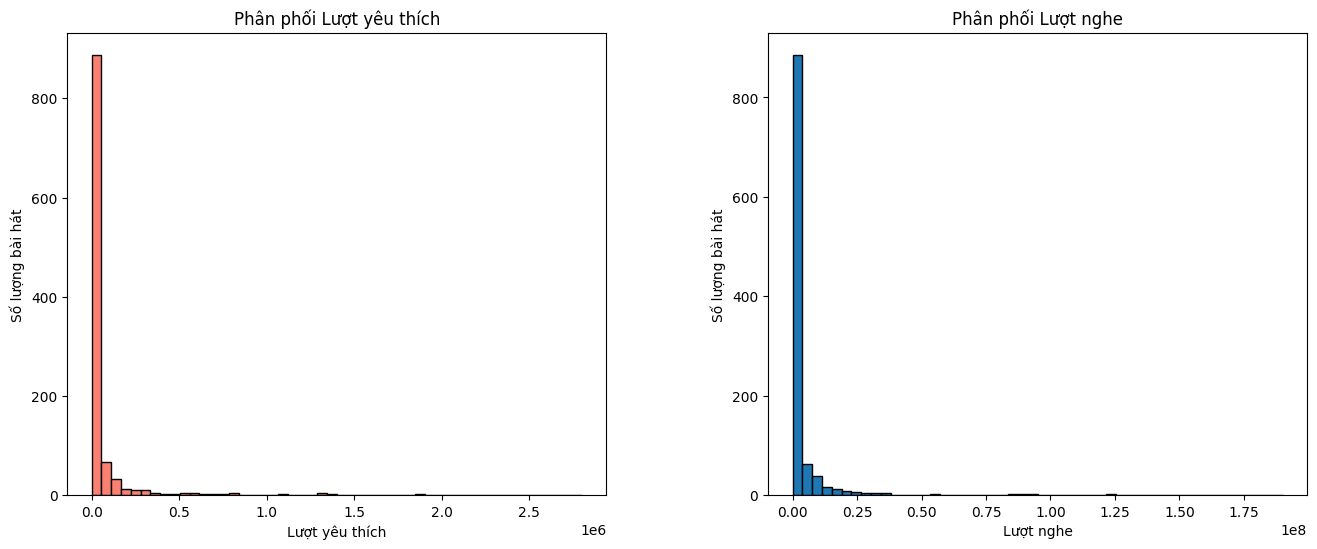

In [16]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.hist(df_cleaned['Lượt yêu thích'].dropna(), color='salmon', bins=50, edgecolor='black')
plt.title("Phân phối Lượt yêu thích")
plt.xlabel('Lượt yêu thích')
plt.ylabel('Số lượng bài hát')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.hist(df_cleaned['Lượt nghe'].dropna(), bins=50, edgecolor='black')
plt.title("Phân phối Lượt nghe")
plt.xlabel('Lượt nghe')
plt.ylabel('Số lượng bài hát')

plt.subplots_adjust(wspace=0.3)
plt.show()


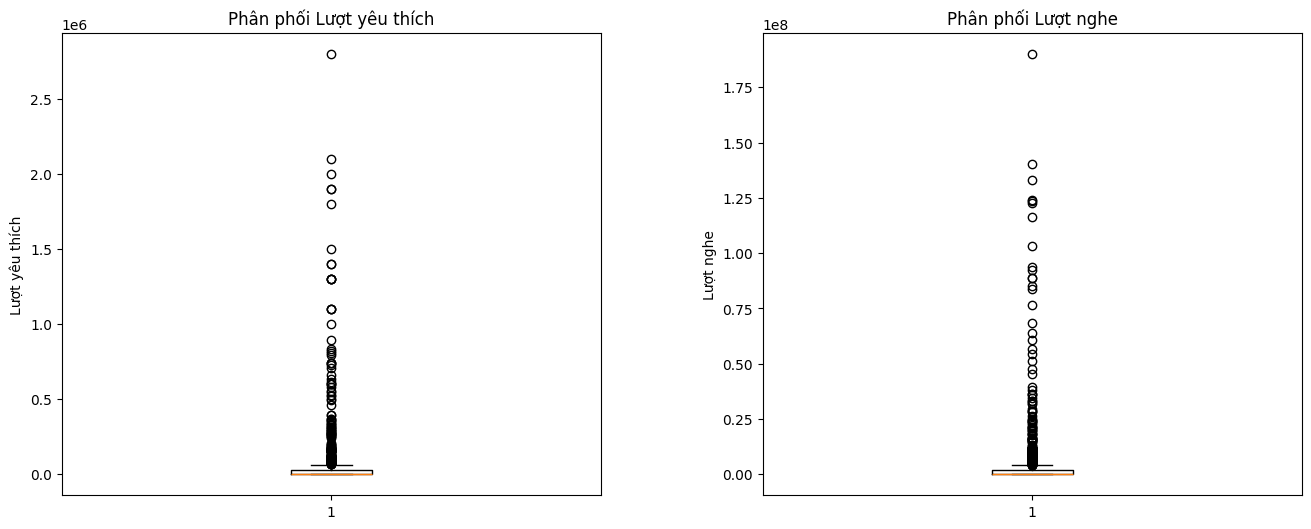

In [17]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.boxplot(df_cleaned['Lượt yêu thích'].dropna())
plt.title("Phân phối Lượt yêu thích")
plt.ylabel('Lượt yêu thích')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.boxplot(df_cleaned['Lượt nghe'].dropna())
plt.title("Phân phối Lượt nghe")
plt.ylabel('Lượt nghe')

plt.subplots_adjust(wspace=0.3)
plt.show()


$\rightarrow$ Tồn tại rất nhiều giá trị ngoại lai

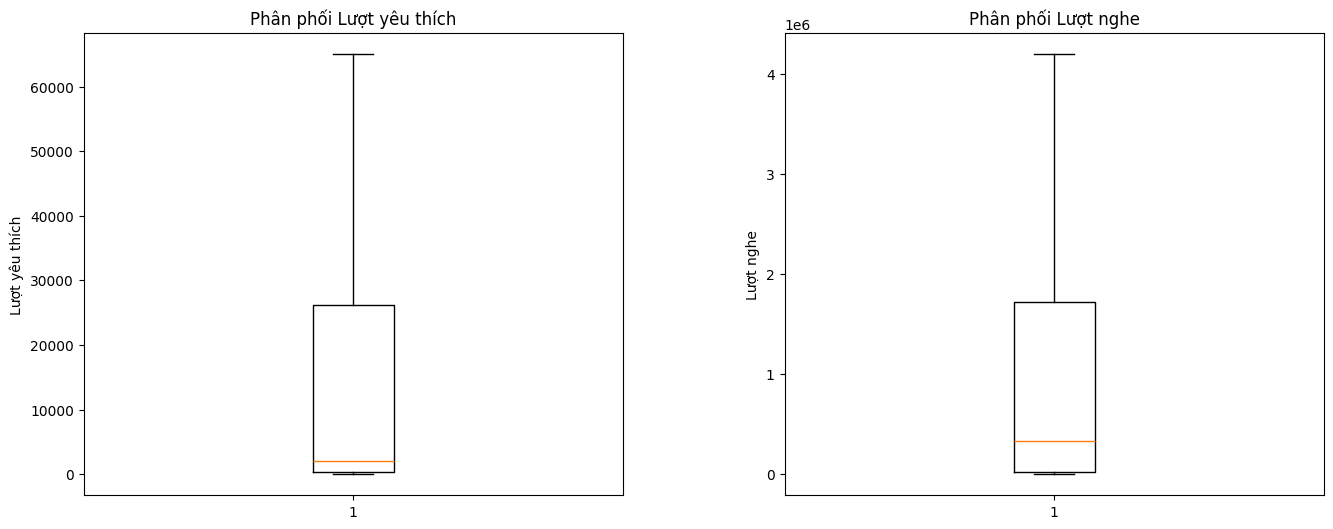

In [18]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.boxplot(df_cleaned['Lượt yêu thích'].dropna(), showfliers=False)
plt.title("Phân phối Lượt yêu thích")
plt.ylabel('Lượt yêu thích')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.boxplot(df_cleaned['Lượt nghe'].dropna(), showfliers=False)
plt.title("Phân phối Lượt nghe")
plt.ylabel('Lượt nghe')

plt.subplots_adjust(wspace=0.3)
plt.show()


#### **Tách giá trị ở cột `Thể loại` thành 2 cột chứa 'thể loại' và 'quốc gia, châu lục' riêng biệt**

In [19]:
theloai_df = df_cleaned['Thể loại'] 

theloai_df.head()

0    Việt Nam, V-Pop
1    Việt Nam, V-Pop
2    Việt Nam, V-Pop
3    Việt Nam, V-Pop
4    Việt Nam, V-Pop
Name: Thể loại, dtype: object

- Kiểm tra xem trước dấu phẩy của cột `Thể loại` có phải hoàn toàn là cụ thể một quốc gia, châu lục nào đó không?

In [20]:
theloai_df.str.split(',').str[0].unique()

array(['Việt Nam', 'V-Pop', nan, 'Âu Mỹ', 'Pop', 'Hàn Quốc', 'Rap Việt',
       'Nhạc Trữ Tình', 'Hòa Tấu', 'Hoa Ngữ', 'Nhạc Phim', 'Nhạc Trịnh',
       'Nhạc Không Lời', 'Nhạc Thiếu Nhi', 'Dance Việt', 'Rock Việt',
       'Nhật Bản', 'Khác', 'Saxophone', 'Classical'], dtype=object)

$\rightarrow$ Các quốc gia có thể là: **Việt Nam, Âu Mỹ, Hàn Quốc, Trung Quốc, Nhật Bản**. Còn lại là thuộc phần thể loại.

Trong ngữ cảnh này, các giá trị như V-Pop, Rap Việt, Nhạc Trữ Tình, Nhạc Trịnh, Dance Việt, Rock Việt là của **Việt Nam**.

In [21]:
countries_list = ['Việt Nam', 'Âu Mỹ', 'Hàn Quốc', 'Nhật Bản']
vn_list = ['V-Pop', 'Rap Việt', 'Nhạc Trữ Tình', 'Nhạc Trịnh', 'Dance Việt', 'Rock Việt']

def process_type_col_country(str_val):
    if isinstance(str_val, str):
        for country in countries_list:
            if country in str_val:
                return country

        for genre in vn_list:
            if genre in str_val:
                return 'Việt Nam'

    return None
    
def process_type_col_type(str_val):
    if isinstance(str_val, str):
        for country in countries_list:
            if country in str_val:
                str_val = str_val.replace(country, '').strip(', ').strip()

        str_val = re.sub(r',\s*,', ',', str_val)  # Thay thế nhiều dấu phẩy bằng một
        
        return str_val if str_val else 'Không rõ'
    else:
        return None

In [22]:
df_cleaned['Thể loại'] = theloai_df.apply(process_type_col_type)
df_cleaned['Quốc gia'] = theloai_df.apply(process_type_col_country)

df_cleaned.head(10)

,Tên bài hát,Album,Lượt yêu thích,Lượt nghe,Nghệ sĩ,Sáng tác,Thể loại,Nhà cung cấp,Lượt yêu thích (dễ nhìn),Lượt nghe (dễ nhìn),Quốc gia
0,Mất Kết Nối,Dữ Liệu Quý (EP),582000.0,23600000.0,Dương Domic,Dương Domic,V-Pop,DAO Music Entertainment,582K,23.6M,Việt Nam
1,Tái Sinh,MULTIVERSE,744000.0,24100000.0,Tùng Dương,Tăng Duy Tân,V-Pop,+84 Vietnam New Wave,744K,24.1M,Việt Nam
2,Mộng Hoa Sim,Mộng Hoa Sim (Single),NaN,NaN,Thiên Tú,Thiên Tú,V-Pop,MIXUS,NaN,NaN,Việt Nam
3,Anh Đau Từ Lúc Em Đi,Anh Đau Từ Lúc Em Đi (Single),501000.0,18100000.0,Trần Mạnh Cường,Trần Mạnh Cường,V-Pop,Incom,501K,18.1M,Việt Nam
4,Cảm Ơn Em,Cảm Ơn Em (Single),279000.0,10000000.0,Đặng Thiên Chí,Đặng Thiên Chí,V-Pop,VIEENT Music,279K,10M,Việt Nam
5,Ánh Mắt Biết Cười,Ánh Mắt Biết Cười (Single),103000.0,2800000.0,"Quang Hùng MasterD, Tăng Duy Tân","Lê Quang Hùng, Tăng Duy Tân",V-Pop,Euphoria Media Vietnam,103K,2.8M,Việt Nam
6,E Là Không Thể,E Là Không Thể (Single),398000.0,16200000.0,Anh Quân,Đông Thiên Đức,V-Pop,DAO Music Entertainment,398K,16.2M,Việt Nam
7,Thủy Triều,Thủy Triều (Single),NaN,NaN,Quang Hùng MasterD,Quang Hùng MasterD,V-Pop,Euphoria Media Vietnam,NaN,NaN,Việt Nam
8,Cô Phòng,Cô Phòng (EP),NaN,NaN,"Hồ Quang Hiếu, Huỳnh Văn",Huỳnh Văn,V-Pop,TECHBEAT Music,NaN,NaN,Việt Nam
9,Tự Hào Màu Áo Lính,Tự Hào Màu Áo Lính (Single),NaN,NaN,Thái Học,Long Họ Huỳnh,V-Pop,MIXUS,NaN,NaN,Việt Nam


#### **Kiểm tra cột có dữ liệu bị thiếu không?**

In [23]:
missing_df = df_cleaned.isnull().sum()

print("Tổng dữ liệu bị thiếu ở mỗi cột")
missing_df

Tổng dữ liệu bị thiếu ở mỗi cột


Tên bài hát                    0
Album                        246
Lượt yêu thích              2336
Lượt nghe                   2336
Nghệ sĩ                       20
Sáng tác                     905
Thể loại                      75
Nhà cung cấp                  15
Lượt yêu thích (dễ nhìn)    2336
Lượt nghe (dễ nhìn)         2336
Quốc gia                     672
dtype: int64

- Cách thức xử lý dữ liệu thiếu:
    - Đối với cột `Album`, điền tên bài hát vào vì nếu để ý, ở nhiều bài hát có tên album khá giống với tên bài hát.
    - Cột `Nghệ sĩ` sẽ điền *'Không rõ'*.
    - Ở cột `Lượt yêu thích` và `Lượt nghe` sẽ lấy *mean* để điền vào chỗ missing. Sau đó điền vào cột `Lượt yêu thích (dễ nhìn)`, và `Lượt nghe (dễ nhìn)`
    - Dữ liệu được thu thập vào thời điểm năm 2025, là thời điểm cũng có nhiều ca sĩ kiêm nhạc sĩ, thế nên đối với dữ liệu bị thiếu ở cột `Sáng tác`, CÓ THỂ được điền tên của nghệ sĩ xuất hiện đầu tiên trong cột `Nghệ sĩ`.
    - Tương tự, cũng có nhiều nghệ sĩ tự phát hành âm nhạc của mình, cũng thực hiện việc xử lý dữ liệu thiêu ở cột `Nhà cung cấp` bằng cách *'Cá nhân'*.
    - Còn lại, đối với cột `Thể loại chính`, `Quốc gia`, vì dữ liệu được thu thập theo thứ tự từng album, nên các bài hát thường sẽ có thể loại tương tự nhau. Thế nên, dữ liệu sẽ được điền dựa trên bài hát trước đó.
    - Cột `Thể loại` sẽ được điền giống với cột `Thể loại chính`.

-  Xử lý dữ liệu thiếu ở cột `Album`: 

In [24]:
df_cleaned['Album'] = df_cleaned['Album'].fillna(df_cleaned['Tên bài hát'])

In [25]:
print(f"Tổng dữ liệu sau khi xử lý ở cột 'Album': {df_cleaned['Album'].isnull().sum()}")

Tổng dữ liệu sau khi xử lý ở cột 'Album': 0


-  Xử lý dữ liệu thiếu ở cột `Nghệ sĩ`: 

In [26]:
df_cleaned['Nghệ sĩ'] = df_cleaned['Nghệ sĩ'].fillna('Không rõ')

In [27]:
print(f"Tổng dữ liệu sau khi xử lý ở cột 'Nghệ sĩ': {df_cleaned['Nghệ sĩ'].isnull().sum()}")

Tổng dữ liệu sau khi xử lý ở cột 'Nghệ sĩ': 0


- Xử lý dữ liệu ở cột `Lượt yêu thích`, `Lượt nghe`, `Lượt yêu thích (dễ nhìn)`, và `Lượt nghe (dễ nhìn)`

In [28]:
print(df_cleaned['Thể loại'].unique().tolist())

['V-Pop', 'Dance Việt', 'Rap Việt', 'Nhạc Phim, V-Pop', 'EDM Việt', 'R&B Việt', None, 'Pop', 'Pop, R&B / Soul', 'Pop, Electronic / Dance', 'Electronic / Dance, Pop', 'Alternative, Pop', 'Pop, Rap / Hip Hop', 'Pop, Nhạc Phim', 'Không rõ', 'Pop/Pop Ballad', 'Dance Pop', 'Rap / Hip Hop', 'Nhạc Phim', 'Rap Việt, R&B Việt', 'Electronic / Dance', 'Electronic / Dance, Trance / House / Techno', 'Nhạc Trữ Tình', 'Nhạc Trữ Tình, Nhạc Dân Ca - Quê Hương', 'V-Pop, Nhạc Trữ Tình', 'Hòa Tấu, Piano', 'Hòa Tấu, Guitar', 'Hòa Tấu, Guitar, Saxophone', 'Blues / Jazz', 'Folk', 'R&B / Soul', 'Rap / Hip Hop, R&B / Soul', 'R&B / Soul, Rap / Hip Hop', 'R&B / Soul, Pop', 'Folk, R&B / Soul', 'Hòa Tấu, Classical', 'Hòa Tấu', 'Classical', 'Hoa Ngữ', 'V-Pop, EDM Việt', 'V-Pop, Nhạc Phim', 'Rap Việt, Nhạc Phim', 'Rock Việt, Nhạc Phim', 'Nhạc Phim, Dance Việt', 'Nhạc Trịnh', 'Nhạc Trữ Tình, Nhạc Trịnh, Tết', 'Nhạc Trữ Tình, Nhạc Trịnh', 'Cải Lương', 'Nhạc Không Lời', 'Nhạc Không Lời, EDM Việt', 'Nhạc Thiếu Nhi', 'Nh

Vì ở cột `Thể loại` có nhiều thể loại và tập thể loại khác nhau, nên để thuận tiện cho việc lấy median, thêm cột mới có tên `Thể loại chính` dựa trên [10 thể loại nhạc phổ biến hiện nay](https://antuan.vn/top-10-the-loai-nhac-pho-bien-hien-nay/) và một số loại nhạc phổ biến ở Việt Nam và các nước Đông Nam Á như Nhạc Trữ tình, Nhạc Cách Mạng, Nhạc Trịnh, Cải Lương, hay Nhạc Thiếu Nhi, Hòa Tấu, ....

In [29]:
general_music_types = ['Pop', 'Rock', 'Country', 'EDM', 'Jazz', 'Blues', 'Dance', 'Ballad', 'R&B', 'Nhạc Trữ tình', 'Nhạc Cách Mạng', 'Nhạc Trịnh', 'Cải Lương', 'Nhạc Thiếu Nhi', 'Hòa Tấu', 'Nhạc Phim']

In [30]:
def gen_general_music_type(str_val):
    if isinstance(str_val, str):
        music_types = re.split('[,/]', str_val)
        music_types = [type.strip() for type in music_types]
        
        if music_types[0] in general_music_types:
            return music_types[0]
        
        else:
            for type in general_music_types:
                if any(type in music for music in music_types):
                    return type
                
    return 'Khác'

In [31]:
df_cleaned['Thể loại chính'] = df_cleaned['Thể loại'].apply(gen_general_music_type)

df_cleaned.head(10)

,Tên bài hát,Album,Lượt yêu thích,Lượt nghe,Nghệ sĩ,Sáng tác,Thể loại,Nhà cung cấp,Lượt yêu thích (dễ nhìn),Lượt nghe (dễ nhìn),Quốc gia,Thể loại chính
0,Mất Kết Nối,Dữ Liệu Quý (EP),582000.0,23600000.0,Dương Domic,Dương Domic,V-Pop,DAO Music Entertainment,582K,23.6M,Việt Nam,Pop
1,Tái Sinh,MULTIVERSE,744000.0,24100000.0,Tùng Dương,Tăng Duy Tân,V-Pop,+84 Vietnam New Wave,744K,24.1M,Việt Nam,Pop
2,Mộng Hoa Sim,Mộng Hoa Sim (Single),NaN,NaN,Thiên Tú,Thiên Tú,V-Pop,MIXUS,NaN,NaN,Việt Nam,Pop
3,Anh Đau Từ Lúc Em Đi,Anh Đau Từ Lúc Em Đi (Single),501000.0,18100000.0,Trần Mạnh Cường,Trần Mạnh Cường,V-Pop,Incom,501K,18.1M,Việt Nam,Pop
4,Cảm Ơn Em,Cảm Ơn Em (Single),279000.0,10000000.0,Đặng Thiên Chí,Đặng Thiên Chí,V-Pop,VIEENT Music,279K,10M,Việt Nam,Pop
5,Ánh Mắt Biết Cười,Ánh Mắt Biết Cười (Single),103000.0,2800000.0,"Quang Hùng MasterD, Tăng Duy Tân","Lê Quang Hùng, Tăng Duy Tân",V-Pop,Euphoria Media Vietnam,103K,2.8M,Việt Nam,Pop
6,E Là Không Thể,E Là Không Thể (Single),398000.0,16200000.0,Anh Quân,Đông Thiên Đức,V-Pop,DAO Music Entertainment,398K,16.2M,Việt Nam,Pop
7,Thủy Triều,Thủy Triều (Single),NaN,NaN,Quang Hùng MasterD,Quang Hùng MasterD,V-Pop,Euphoria Media Vietnam,NaN,NaN,Việt Nam,Pop
8,Cô Phòng,Cô Phòng (EP),NaN,NaN,"Hồ Quang Hiếu, Huỳnh Văn",Huỳnh Văn,V-Pop,TECHBEAT Music,NaN,NaN,Việt Nam,Pop
9,Tự Hào Màu Áo Lính,Tự Hào Màu Áo Lính (Single),NaN,NaN,Thái Học,Long Họ Huỳnh,V-Pop,MIXUS,NaN,NaN,Việt Nam,Pop


In [32]:
likes_mean = df_cleaned['Lượt yêu thích'].mean().round()

df_cleaned['Lượt yêu thích'] = df_cleaned['Lượt yêu thích'].fillna(likes_mean)

In [33]:
print(f"Tổng dữ liệu còn thiếu ở cột 'Lượt yêu thích': {df_cleaned['Lượt yêu thích'].isnull().sum()}")

Tổng dữ liệu còn thiếu ở cột 'Lượt yêu thích': 0


In [34]:
listening_mean = df_cleaned['Lượt nghe'].mean().round()

df_cleaned['Lượt nghe'] = df_cleaned['Lượt nghe'].fillna(listening_mean)

In [35]:
print(f"Tổng dữ liệu còn thiếu ở cột 'Lượt nghe': {df_cleaned['Lượt nghe'].isnull().sum()}")

Tổng dữ liệu còn thiếu ở cột 'Lượt nghe': 0


In [36]:
def convert_visible_numeric(val):
    if val < 1000:
        return val
    elif 1000 <= val < 1e6:
        return str(val // 1000) + 'K'
    else:
        return str(val // 1e6) + 'M'

In [37]:
df_cleaned['Lượt yêu thích (dễ nhìn)'] = df_cleaned['Lượt yêu thích'].apply(convert_visible_numeric)
df_cleaned['Lượt nghe (dễ nhìn)'] = df_cleaned['Lượt nghe'].apply(convert_visible_numeric)

In [38]:
df_cleaned.head(10)

,Tên bài hát,Album,Lượt yêu thích,Lượt nghe,Nghệ sĩ,Sáng tác,Thể loại,Nhà cung cấp,Lượt yêu thích (dễ nhìn),Lượt nghe (dễ nhìn),Quốc gia,Thể loại chính
0,Mất Kết Nối,Dữ Liệu Quý (EP),582000.0,23600000.0,Dương Domic,Dương Domic,V-Pop,DAO Music Entertainment,582.0K,23.0M,Việt Nam,Pop
1,Tái Sinh,MULTIVERSE,744000.0,24100000.0,Tùng Dương,Tăng Duy Tân,V-Pop,+84 Vietnam New Wave,744.0K,24.0M,Việt Nam,Pop
2,Mộng Hoa Sim,Mộng Hoa Sim (Single),64995.0,4246475.0,Thiên Tú,Thiên Tú,V-Pop,MIXUS,64.0K,4.0M,Việt Nam,Pop
3,Anh Đau Từ Lúc Em Đi,Anh Đau Từ Lúc Em Đi (Single),501000.0,18100000.0,Trần Mạnh Cường,Trần Mạnh Cường,V-Pop,Incom,501.0K,18.0M,Việt Nam,Pop
4,Cảm Ơn Em,Cảm Ơn Em (Single),279000.0,10000000.0,Đặng Thiên Chí,Đặng Thiên Chí,V-Pop,VIEENT Music,279.0K,10.0M,Việt Nam,Pop
5,Ánh Mắt Biết Cười,Ánh Mắt Biết Cười (Single),103000.0,2800000.0,"Quang Hùng MasterD, Tăng Duy Tân","Lê Quang Hùng, Tăng Duy Tân",V-Pop,Euphoria Media Vietnam,103.0K,2.0M,Việt Nam,Pop
6,E Là Không Thể,E Là Không Thể (Single),398000.0,16200000.0,Anh Quân,Đông Thiên Đức,V-Pop,DAO Music Entertainment,398.0K,16.0M,Việt Nam,Pop
7,Thủy Triều,Thủy Triều (Single),64995.0,4246475.0,Quang Hùng MasterD,Quang Hùng MasterD,V-Pop,Euphoria Media Vietnam,64.0K,4.0M,Việt Nam,Pop
8,Cô Phòng,Cô Phòng (EP),64995.0,4246475.0,"Hồ Quang Hiếu, Huỳnh Văn",Huỳnh Văn,V-Pop,TECHBEAT Music,64.0K,4.0M,Việt Nam,Pop
9,Tự Hào Màu Áo Lính,Tự Hào Màu Áo Lính (Single),64995.0,4246475.0,Thái Học,Long Họ Huỳnh,V-Pop,MIXUS,64.0K,4.0M,Việt Nam,Pop


- Xử lý ở cột `Sáng tác` và `Nhà cung cấp`

In [39]:
df_cleaned['Sáng tác'] = df_cleaned['Sáng tác'].fillna(df_cleaned['Nghệ sĩ'])
df_cleaned['Nhà cung cấp'] = df_cleaned['Nhà cung cấp'].fillna('Cá nhân')

In [40]:
print(f"Tổng dữ liệu còn thiếu ở cột 'Sáng tác': {df_cleaned['Sáng tác'].isnull().sum()}")
print(f"Tổng dữ liệu còn thiếu ở cột 'Nhà cung cấp': {df_cleaned['Nhà cung cấp'].isnull().sum()}")

Tổng dữ liệu còn thiếu ở cột 'Sáng tác': 0
Tổng dữ liệu còn thiếu ở cột 'Nhà cung cấp': 0


- Xử lý cột `Thể loại chính`, `Quốc gia`

In [41]:
df_cleaned['Thể loại chính'] = df_cleaned['Thể loại chính'].ffill()
df_cleaned['Quốc gia'] = df_cleaned['Quốc gia'].ffill()

In [42]:
print(f"Tổng dữ liệu còn thiếu ở cột 'Thể loại chính': {df_cleaned['Thể loại chính'].isnull().sum()}")
print(f"Tổng dữ liệu còn thiếu ở cột 'Quốc gia': {df_cleaned['Quốc gia'].isnull().sum()}")

Tổng dữ liệu còn thiếu ở cột 'Thể loại chính': 0
Tổng dữ liệu còn thiếu ở cột 'Quốc gia': 0


- Xử lý cột `Thể loại`

In [43]:
df_cleaned['Thể loại'] = df_cleaned['Thể loại'].fillna(df_cleaned['Thể loại chính'])

In [44]:
print(f"Tổng dữ liệu còn thiếu ở cột 'Thể loại': {df_cleaned['Thể loại'].isnull().sum()}")

Tổng dữ liệu còn thiếu ở cột 'Thể loại': 0


In [45]:
print('Tống giá trị bị thiếu trong các cột sau khi xử lý:')

df_cleaned.isnull().sum()

Tống giá trị bị thiếu trong các cột sau khi xử lý:


Tên bài hát                 0
Album                       0
Lượt yêu thích              0
Lượt nghe                   0
Nghệ sĩ                     0
Sáng tác                    0
Thể loại                    0
Nhà cung cấp                0
Lượt yêu thích (dễ nhìn)    0
Lượt nghe (dễ nhìn)         0
Quốc gia                    0
Thể loại chính              0
dtype: int64

#### **Với cột có dữ liệu số, giá trị phân bố như thế nào sau khi được xử lý?**

In [46]:
df_cleaned.describe(include=[np.number]).apply(lambda s: s.apply('{:,.0f}'.format))

,Lượt yêu thích,Lượt nghe
count,"3,404","3,404"
mean,"64,995","4,246,475"
std,"127,066","8,374,757"
min,3,279
25%,"40,000","2,800,000"
50%,"64,995","4,246,475"
75%,"64,995","4,246,475"
max,"2,800,000","190,000,000"


$\rightarrow$ Các giá trị phần trăm cho thấy sự phân bố đồng đều hơn trong dữ liệu, nhưng sự chênh lệch lớn giữa min và max cho thấy sự xuất hiện của các ngoại lệ và phân phối vẫn bị lệch phải.

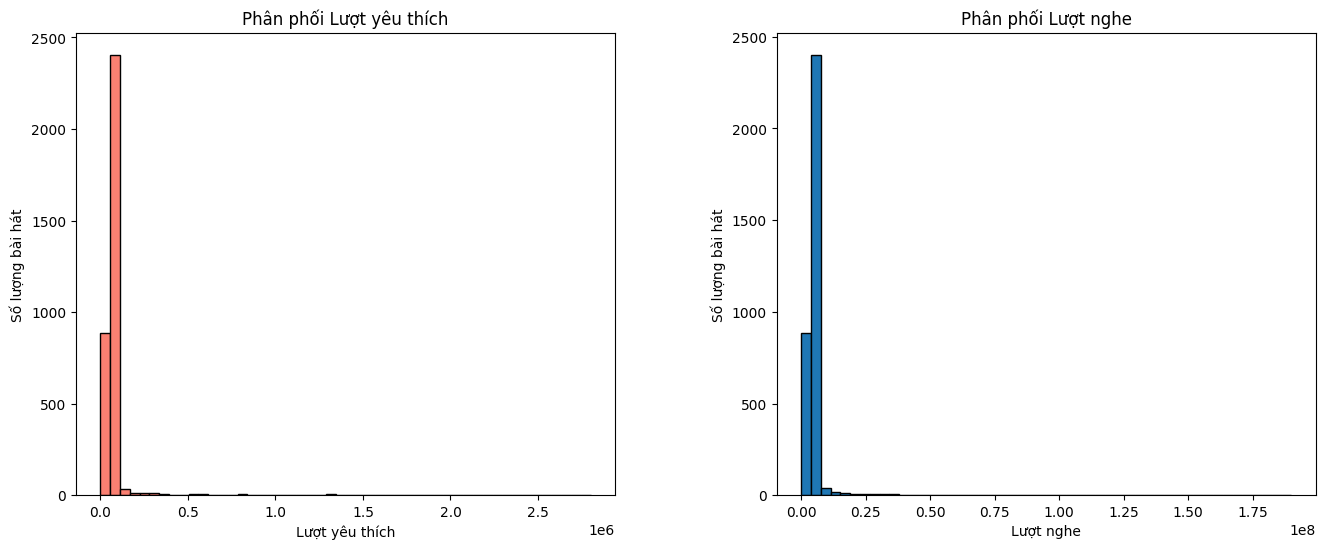

In [47]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.hist(df_cleaned['Lượt yêu thích'], color='salmon', bins=50, edgecolor='black')
plt.title("Phân phối Lượt yêu thích")
plt.xlabel('Lượt yêu thích')
plt.ylabel('Số lượng bài hát')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.hist(df_cleaned['Lượt nghe'], bins=50, edgecolor='black')
plt.title("Phân phối Lượt nghe")
plt.xlabel('Lượt nghe')
plt.ylabel('Số lượng bài hát')

plt.subplots_adjust(wspace=0.3)
plt.show()


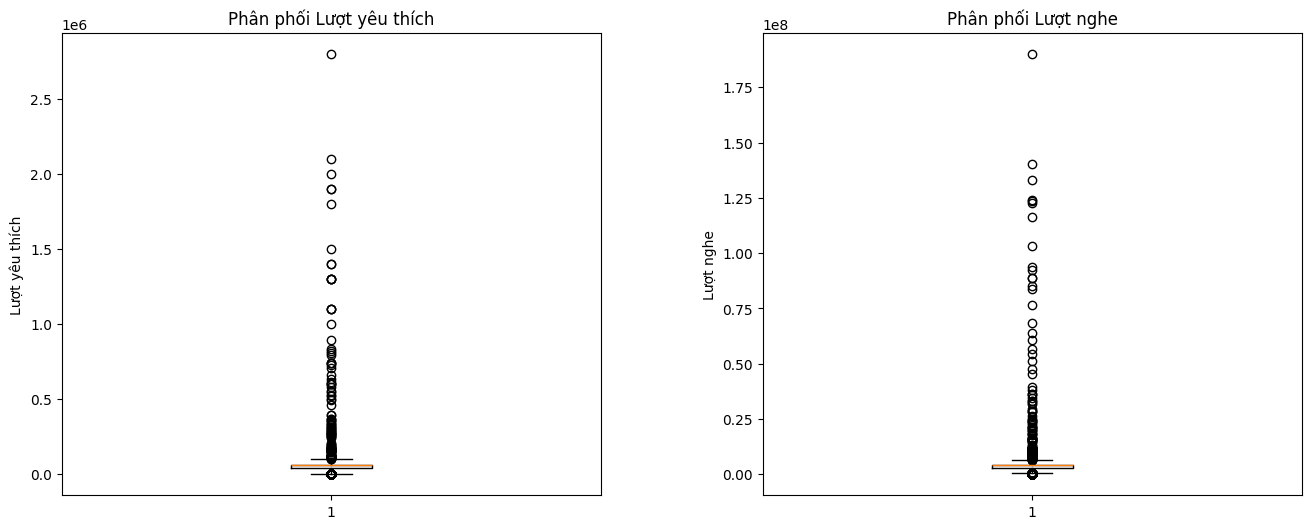

In [48]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.boxplot(df_cleaned['Lượt yêu thích'])
plt.title("Phân phối Lượt yêu thích")
plt.ylabel('Lượt yêu thích')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.boxplot(df_cleaned['Lượt nghe'])
plt.title("Phân phối Lượt nghe")
plt.ylabel('Lượt nghe')

plt.subplots_adjust(wspace=0.3)
plt.show()


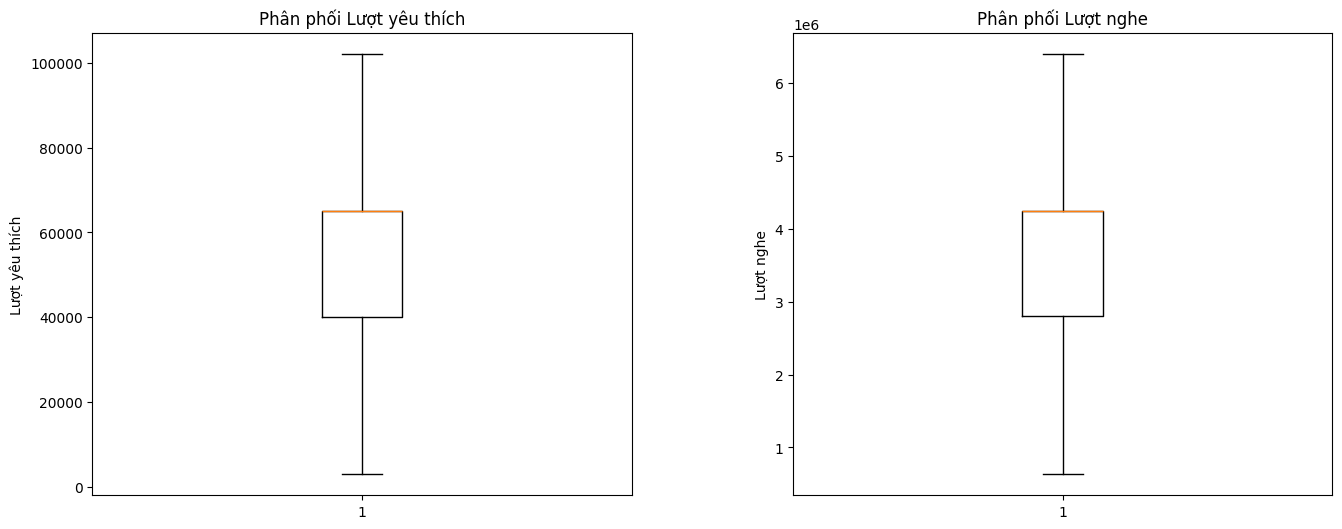

In [49]:
plt.figure(figsize=(16, 6))

#Lượt yêu thích
plt.subplot(1, 2, 1)
plt.boxplot(df_cleaned['Lượt yêu thích'], showfliers=False)
plt.title("Phân phối Lượt yêu thích")
plt.ylabel('Lượt yêu thích')

# Lượt nghe
plt.subplot(1, 2, 2)
plt.boxplot(df_cleaned['Lượt nghe'], showfliers=False)
plt.title("Phân phối Lượt nghe")
plt.ylabel('Lượt nghe')

plt.subplots_adjust(wspace=0.3)
plt.show()


$\rightarrow$ So với ban đầu, các khoảng tứ phân vị và phân bố giá trị có sự thay đổi tăng lên đáng kể. Hơn nữa, phân phối cũng đều hơn so với ban đầu, khi so với ban đầu, không còn tập trung quá mức ở một phạm vi nhỏ.

<Axes: >

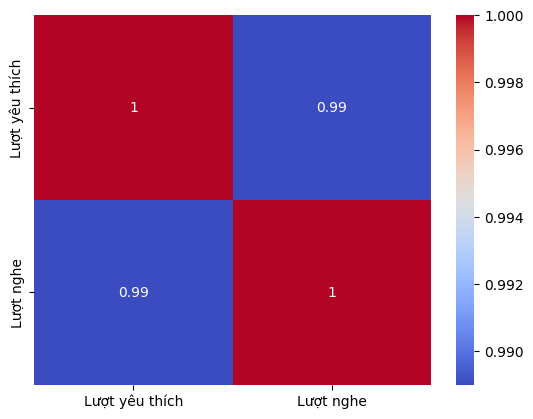

In [50]:
numeric_df = df_cleaned.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr().round(3)

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

$\rightarrow$ Sự tương quan giữa lượt nghe và lượt cực kì cao. Nghĩa là cả 2 cột này đều có xu hướng thay đổi giống nhau.

#### **Các cột có dữ liệu số phân phối như nào?**

In [51]:
cat_cols = df_cleaned.select_dtypes(include=['category', 'object']).drop(columns=['Lượt yêu thích (dễ nhìn)', 'Lượt nghe (dễ nhìn)', 'Thể loại'], errors='ignore')

In [52]:
def value_ratios(column):
    value_count_percentage = column.value_counts(normalize=True) * 100
    ratio = value_count_percentage.sort_values(ascending=False).round(2).to_dict()
    return ratio

In [53]:
cat_col_ratio = cat_cols.agg([value_ratios])
cat_col_ratio

,Tên bài hát,Album,Nghệ sĩ,Sáng tác,Nhà cung cấp,Quốc gia,Thể loại chính
value_ratios,"{'Còn Tuổi Nào Cho Em': 0.18, 'Mưa Hồng': 0.15, 'Someone You Loved': 0.12, 'Flowers': 0.12, 'Cô Ba': 0.12, 'Em Còn Nhớ Hay Em Đã Quên': 0.12, 'Tuổi Đá Buồn': 0.12, 'Đừng Hỏi Em Ổn Không…': 0.12, 'Người Tình Trên Chiến Trận': 0.12, 'Một Cõi Đi Về': 0.12, 'Nắng Thủy Tinh': 0.12, 'Numb': 0.09, 'Con Cò Bé Bé': 0.09, 'Đừng Trách Câu Ví Dặm': 0.09, 'Đêm Lạnh Chùa Hoang': 0.09, 'Lucky': 0.09, 'Biển Nhớ': 0.09, 'Ngày Mai Người Ta Lấy…': 0.09, 'Cát Bụi': 0.09, 'Hạ Trắng': 0.09, 'Nỗi Buồn Em Đánh Rơi…': 0.09, 'Tìm Em Câu Ví Sông Lam': 0.09, '凝眸': 0.09, 'Lý Chim Quyên': 0.09, 'Bài Ca Xây Dựng': 0.09, 'Adagio Concerto For Oboe…': 0.09, 'Diễm Xưa': 0.09, 'Anh Thôi Nhân Nhượng…': 0.09, 'Hà Tĩnh Quê Ơi': 0.09, 'Tình Nhớ': 0.09, 'Đò Sang Ngang': 0.06, 'Fall In Love': 0.06, 'Waterfall': 0.06, 'Huyền Thoại Mẹ': 0.06, 'Allegro Concerto For Oboe…': 0.06, 'Cô Đôi Thượng Ngàn': 0.06, 'Ôm Sầu (Remix)': 0.06, 'Gurenge': 0.06, 'Send It': 0.06, 'Ru Ta Ngậm Ngùi': 0.06, '8 Vạn 6 Ngàn Thương': 0.06, 'E Là Không Thể': 0.06, 'Smile': 0.06, 'Sumeru Aranara Song…': 0.06, 'Gorg Philipp Telemann…': 0.06, 'Phôi Pha': 0.06, 'Kiếp Sau Vẫn Muốn Lập Gia…': 0.06, 'Skibidi Toilet (Remix)': 0.06, 'Lemon Tree': 0.06, 'Cuối Cùng Cho Một Tình Yêu': 0.06, 'Trả Lại Thanh Xuân Cho Em…': 0.06, 'Ăn Trông Nồi Ngồi Trông…': 0.06, 'Từng Ngày Yêu Em': 0.06, 'Johann Friedrich Fasch…': 0.06, 'Blue': 0.06, 'Đêm Thấy Ta Là Thác Đổ': 0.06, 'Bones': 0.06, 'Như Cánh Vạc Bay': 0.06, 'Trầu Cau Quan Họ': 0.06, 'Buồn Con Sáo Sậu': 0.06, 'Closer': 0.06, 'Lao Tâm Khổ Tứ': 0.06, 'Today': 0.06, 'Cá Vàng Bơi': 0.06, 'Love, Maybe': 0.06, 'Tuổi Đời Mênh Mông': 0.06, 'Khóc Nơi Ta Cười': 0.06, 'KHÔNG RA GÌ': 0.06, 'Khi Yêu Nào Đâu Ai Muốn…': 0.06, 'Charlie Brown Medley': 0.06, 'Chiếc Lá Thu Phai': 0.06, 'Em Cua Ngay Hom Qua…': 0.06, 'Em Có Bằng Lòng Về Quê…': 0.06, 'Hương Tình Bến Tre': 0.06, 'Duyên Nợ Miền Tây': 0.06, 'Đêm Mưa Nhớ Mẹ': 0.06, 'The Moment': 0.06, 'Vương Vấn (Qinn Remix)': 0.06, 'Ướt Mi': 0.06, 'Ru Đời Đi Nhé': 0.06, 'Tái Sinh': 0.06, 'Cung Đàn Mới': 0.06, 'Save Me': 0.06, 'Chiều Một Mình Qua Phố': 0.06, 'Chăm Em Một Đời': 0.06, 'Để Gió Cuốn Đi': 0.06, 'Slowly': 0.06, 'Dấu Chân Địa Đàng': 0.06, 'Rượu Mừng Hóa Người…': 0.06, 'Time Back': 0.06, 'Gửi Người Em Hà Tĩnh': 0.06, 'Ngày Này, Người Con Gái Này': 0.06, 'Heather On The Hill…': 0.06, 'FOREVER': 0.06, 'Words': 0.06, 'Khổ Quá Thì Về Mẹ Nuôi': 0.06, 'Going Home': 0.06, 'Nhớ': 0.06, 'Supernova Love': 0.06, 'Die With A Smile': 0.06, ...}","{'Canti Per La Liturgia, Vol. 4: A Collection of Christian Songs and Catholic Hymns (Single)': 0.85, 'Smooth Piano Jazz Music': 0.71, 'Canti Per La Liturgia, Vol. 5: A Collection of Christian Songs and Catholic Hymns (Single)': 0.68, 'Clasicos Infantiles': 0.62, 'Squid Game 2 (Soundtrack from the Netflix Series)': 0.62, 'Fingerstyle Guitar (Single)': 0.59, 'Nhạc Relax Minh Thống': 0.5, 'Hồ Yêu Tiểu Hồng Nương: Nguyệt Hồng Thiên (OST) / 电视剧《狐妖小红娘月红篇》原声带': 0.5, 'Hurry Up Tomorrow': 0.5, 'Un bel di': 0.41, 'Luxury Classics - A Touch of Class -': 0.41, 'Tuyển Tập Nhạc Trịnh (Vol 2)': 0.38, 'Tuyển Tập Nhạc Trịnh': 0.35, 'Trịnh Ca Vol. 1': 0.35, 'Chess Fantasies (Single)': 0.32, 'Tiếng Sáo Chiều': 0.32, 'Louie O.': 0.32, 'Trịnh Ca Vol. 2': 0.32, 'Our Acoustic Life (Single)': 0.32, 'Saxophone Memories (Single)': 0.29, 'Speak Now (Taylor's Version)': 0.29, 'Đi Đến Nơi Có Gió (OST) / 電視劇《去有風的地方》原聲帶': 0.29, 'Music Box Collection Suda Masaki Song Collection': 0.29, 'Hòa Tấu Guitar': 0.29, 'Ai Cũng Phải Bắt Đầu Từ Đâu Đó': 0.29, 'Liên Hoa Lâu (OST) / 《莲花楼》电视剧原声专辑': 0.29, 'Trịnh Ca 05': 0.29, 'Nhạc Thánh Ca Không Lời Piano Nhẹ Nhàng': 0.29, 'Nguyễn Hải Phong - Nhạc Piano Không Lời Vol.1': 0.29, 'TRỜI ĐÁNH TRÁNH TA - TA VA TRÚNG NGƯỜI': 0.29, 'Relax piano - yellow jelly': 0.29, 'Slow Saxophone Smooth Jazz Music For Lover': 0.29, 'REMIX RUMBLE (Original Soundtrack from Teamfight Tactics Set 10)': 0.26, 'DRIP': 0.26, 'Album Hoa Ta

In [54]:
import warnings
warnings.filterwarnings("ignore")

In [55]:
def plot_pie_chart(column, title, ax):
    ratios = value_ratios(column)
    
    top_10_ratios = dict(list(ratios.items())[:10])
    
    labels = list(top_10_ratios.keys())
    sizes = list(top_10_ratios.values())
    
    labels = [label if len(label) <= 21 else '\n'.join([label[i:i+21] for i in range(0, len(label), 21)]) for label in labels]
    explode = [0.1 if i == sizes.index(max(sizes)) else 0 for i in range(len(sizes))]
    
    # Plot pie chart with adjusted label distance and angle
    ax.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, labeldistance=1.2, pctdistance=0.85, explode=explode)
    ax.set_title(title, pad=15)
    plt.axis('equal')

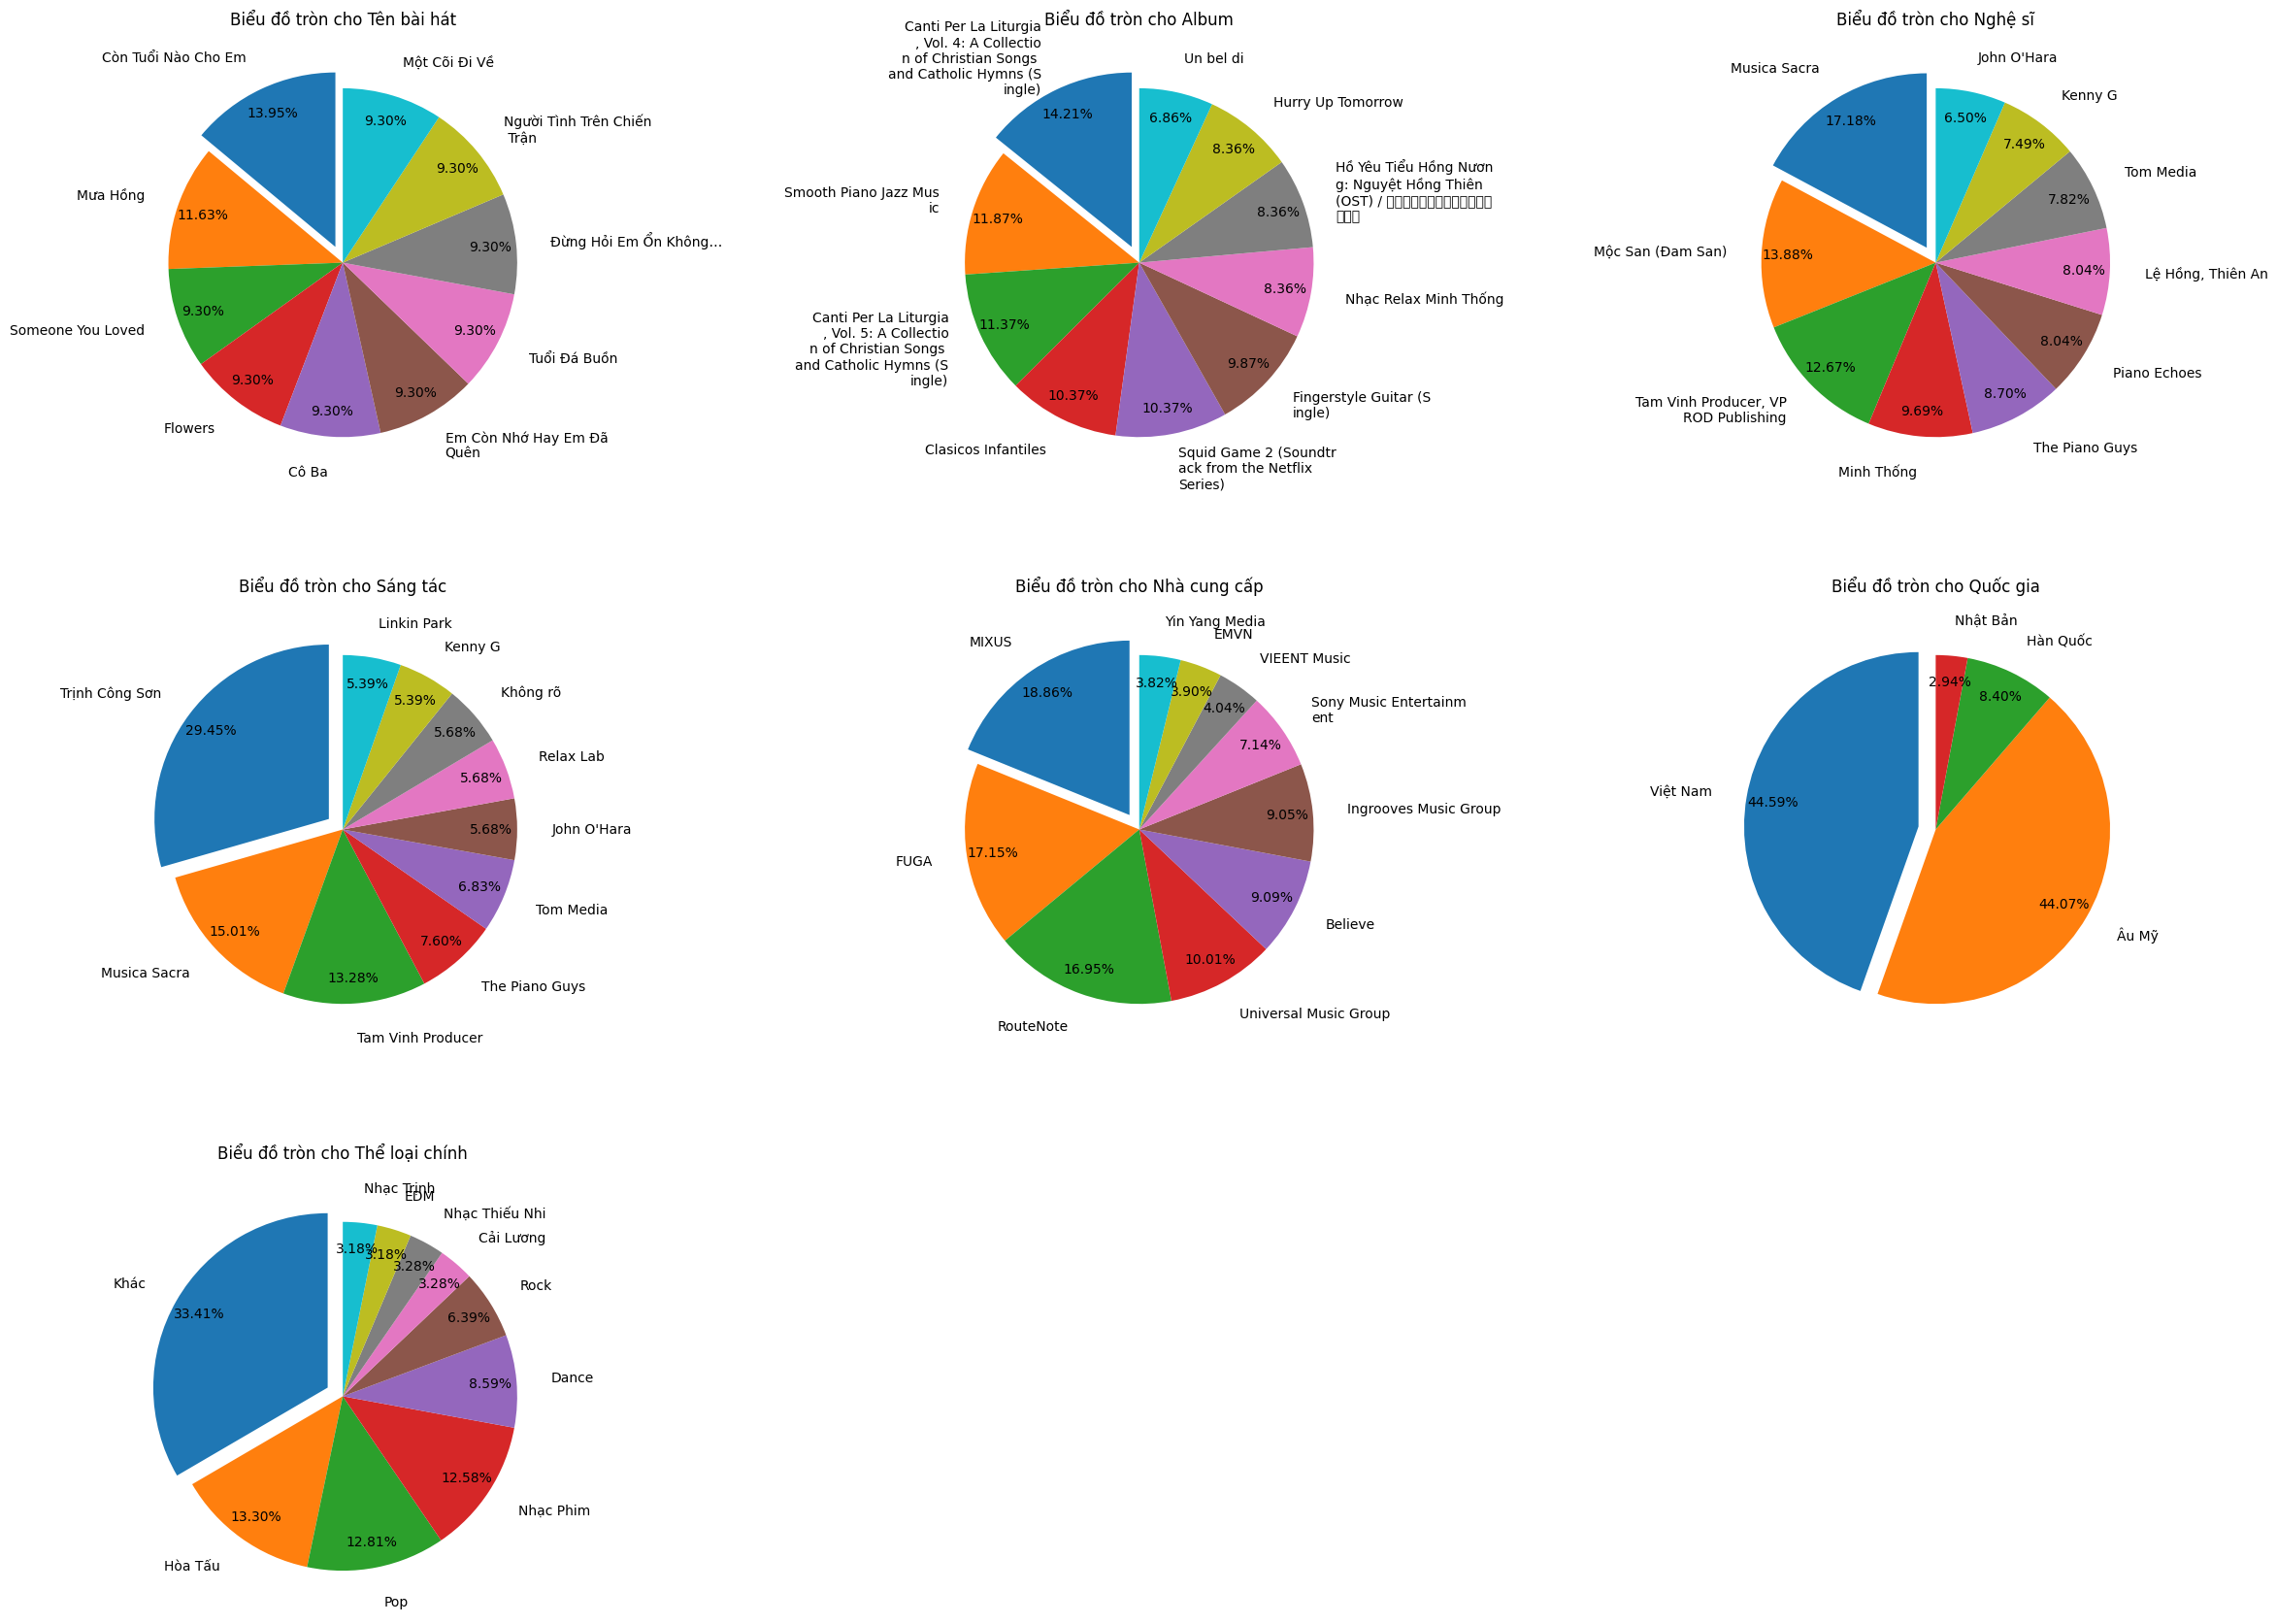

In [56]:
num_cols = len(cat_cols.columns)
rows = (num_cols // 3) + 1  # Số dòng
fig, axes = plt.subplots(rows, 3, figsize=(30, 7 * rows))

axes = axes.flatten()

for i, col in enumerate(cat_cols.columns):
    plot_pie_chart(df_cleaned[col], title=f"Biểu đồ tròn cho {col}", ax=axes[i])

for i in range(num_cols, len(axes)):
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.3) 
plt.show()

Một số kết luận có thể rút ra:
- Ở `Tên bài hát`, bài **'Còn Tuổi Nào Cho Em'**, **'Mưa Hồng'** có tỷ lệ lớn hơn hẳn so với nhiều bài. Đây là những bài hát được trình bày bởi nhiều ca nghệ sĩ khác nhau và xuất hiện nhiều lần trong các album top 100, có thể thấy được đây là những bài hát hay được rất nhiều người nghe, bởi ý nghĩa mà bài hát mang lại hoặc có thể bởi những giai điệu nhẹ nhàng, sâu lắng, bắt tai... Theo sau đó, **Someone You Loved**, **Flowers**, .... Phần lớn là nhạc Việt Nam, cho thấy xu hướng người dùng trên nền tảng ZingMP3 thích nhạc Việt.
- Ngược hẳn với `Tên bài hát` thì `Album`, `Sáng tác` xuất hiện nhiều nhất trong các nền tảng lại là các album và các nhạc sĩ sáng tác ở nước ngoài.
- Trên nền tảng Zing MP3, 'MIXUE', 'FUGA', 'RouteNote' là các `Nhà cung cấp` bài hát, album lớn nhất. 'Universal Music Group', 'Belive' cũng là những hãng thu âm nổi tiếng ở Việt Nam này.
- Phần lớn nhạc trên Zing MP3 là nhạc Việt Nam và nhạc Âu Mỹ
- Có rất nhiều thể loại nhạc khác nhau trên nền tảng nghe nhạc Zing MP3,  trong đó nổi bật nhất trong các album top 100 là các thể loại nhạc 'Hòa Tấu', 'Pop' và 'Nhạc Phim'

## **NGUỒN THAM KHẢO**

1. [Danh sách album để lấy dữ liệu](https://zingmp3.vn/top100)
2. [Cách xác định locators - Java](https://anhtester.com/blog/selenium-java-bai-5-cach-xac-dinh-locators-cua-element-tren-website-b349.html)
2. [Selenium - Action chains in Python](https://www.geeksforgeeks.org/action-chains-in-selenium-python/)
3. [Cách đóng popup](https://www.reddit.com/r/learnpython/comments/12jp1kd/unable_to_locate_the_x_button_in_a_pop_up_message/?rdt=64842)
4. [Top 10 thể loại nhạc phổ biến hiện nay](https://antuan.vn/top-10-the-loai-nhac-pho-bien-hien-nay/) (Cập nhật: 28/05/2024)
5. [ChatGPT](https://chat.openai.com/chat)